# Building a machine learning model to predict the price of an apartment transaction in 2017 and onward.

Overview of steps:
1. Data cleaning and feature engineering
2. Exploratory data analysis
3. Model building and cross validation - explore different techniques for missing data and outliers.
    - Linear regression model (OLS)
    - Lasso regression model
    - XG Boost model
4. Testing best model on test data (data from 2017-2018)

In [1]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("Stryd_Dataset.csv")

/var/folders/_b/2ffr0tvs1zb65ywkqxdpgc5w0000gn/T/ipykernel_86325/2711568177.py:1: DtypeWarning: Columns (0,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Stryd_Dataset.csv")


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318851 entries, 0 to 318850
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   318851 non-null  object 
 1   Lng                  318851 non-null  float64
 2   Lat                  318851 non-null  float64
 3   Cid                  318851 non-null  float64
 4   tradeTime            318851 non-null  object 
 5   DOM                  160874 non-null  float64
 6   followers            318851 non-null  int64  
 7   price                318851 non-null  int64  
 8   square               318851 non-null  float64
 9   livingRoom           318851 non-null  object 
 10  drawingRoom          318851 non-null  object 
 11  kitchen              318851 non-null  int64  
 12  bathRoom             318849 non-null  float64
 13  floorPosition        317580 non-null  object 
 14  floorsCount          318819 non-null  float64
 15  constructionTime 

## Find data entry errors and fix.

In [4]:
# Identify the non-numeric data entries for id.
a = pd.to_numeric(df["id"], errors='coerce')
idx = a.isna()
df[idx]["id"].unique()

# Not worried about these id's that are not numeric.

array(['BJ0000614981', 'BJ0000614985', 'BJ0000614991', ...,
       'BJYZ92324217', 'BJYZ92333313', 'BJYZ92363553'], dtype=object)

In [5]:
# Identify the non-numeric data entries for livingRoom.
a = pd.to_numeric(df["livingRoom"], errors='coerce')
idx = a.isna()
df[idx]["livingRoom"].unique()

array(['#NAME?'], dtype=object)

In [6]:
# Make errors just missing.
df.loc[df["livingRoom"] == '#NAME?', "livingRoom"] = None
df["livingRoom"] = df["livingRoom"].astype(float)

In [7]:
# Identify the non-numeric data entries for drawingRoom.

a = pd.to_numeric(df["drawingRoom"], errors='coerce')
idx = a.isna()
drawing_room_values_to_drop = set(df[idx]["drawingRoom"].unique())
drawing_room_values_to_drop


{'bottom 11',
 'bottom 20',
 'bottom 28',
 'high 12',
 'high 14',
 'high 6',
 'low 15',
 'low 16',
 'low 6',
 'middle 14',
 'middle 15',
 'middle 16',
 'middle 22',
 'middle 24',
 'middle 6',
 'top 6'}

In [8]:
# Get an idea of what legit entries are.
a.unique()


array([ 1.,  2.,  0.,  4.,  3.,  5., nan])

In [9]:
# Errors don't make sense compared to legit entries so make them missing.
df["drawingRoom"] = df["drawingRoom"].apply(lambda x: x if x not in drawing_room_values_to_drop else None) 
df["drawingRoom"] = df["drawingRoom"].astype(float)

In [10]:
# Want tradeTime as dt
df["tradeTime"] = pd.to_datetime(df["tradeTime"])

In [11]:
# Add in the target of interest.
df["total_price"] = df["price"] * df["square"]

In [12]:
# Check categories.
df["floorPosition"].value_counts()

middle    119832
high       70094
low        64136
top        37406
bottom     26080
钢混结构          17
混合结构          15
Name: floorPosition, dtype: int64

In [13]:
correct_floor_positions = set(['high', 'middle', 'bottom', 'low', 'top'])

df["floorPosition"] = df["floorPosition"].apply(lambda x: x if x in correct_floor_positions else None)

In [14]:
# Combine some of the floor positions to decrease number of categories.

midish_floors = set(['high', 'middle', 'low'])

df["floorPositionAbbreviated"] = df["floorPosition"].apply(
    lambda x: "midish" if x in midish_floors else x
)

In [15]:
# Needs to be categorical (not numeric).

df["renovationCondition"].value_counts()

1    118746
4    117438
3     77251
2      5390
0        26
Name: renovationCondition, dtype: int64

In [16]:
df["renovationCondition"] = df["renovationCondition"].apply(lambda x: None if x == 0 else x)
df["renovationCondition"] = df["renovationCondition"].astype(str)

In [17]:
# Needs to be categorical (not numeric).

df["buildingStructure"].value_counts()

6    188067
2    115779
4     14341
3       253
1       196
5       187
0        28
Name: buildingStructure, dtype: int64

In [18]:
df["buildingStructure"] = df["buildingStructure"].apply(lambda x: None if x == 0 else x)
df["buildingStructure"] = df["buildingStructure"].astype(str)

In [19]:
# Needs to be categorical (not numeric).

df["district"].unique()

array([ 7,  6,  1, 13, 10,  2,  8,  4,  5,  3,  9, 12, 11])

In [20]:
sum(df["district"].isna())

0

In [21]:
df["district"] = df["district"].astype(str)

In [22]:
# Check if any entries from before 2009 (instructions say data should be >= 2009).

len(df.query("tradeTime < '2009-01-01'"))

5

In [23]:
# Not many before 2009 so dropping. 

df = df.query("tradeTime >= '2009-01-01'")

In [24]:
# Want tradeTime as numeric so it could potentially be included in the model.
df['tradeTime_numeric'] = pd.to_datetime(df["tradeTime"], format="%Y-%M-%D")
df['tradeTime_numeric'] = df['tradeTime_numeric'].apply(datetime.datetime.toordinal)

In [25]:
# Need to address some outliers.

df.query("constructionTime < 1492")["constructionTime"].max()

1.0

In [26]:
df["constructionTime"] = df["constructionTime"].apply(
    lambda x: None if x < 1492 else x)

In [27]:
df.query("ladderRatio > 2")["ladderRatio"]

18367     1.000000e+01
46633     3.000000e+00
52194     3.000000e+00
61036     1.000940e+07
94795     3.000000e+00
148467    1.000940e+07
165450    5.000000e+00
171061    5.000000e+00
248085    3.333000e+00
256735    3.000000e+00
256976    3.333000e+00
259663    3.000000e+00
Name: ladderRatio, dtype: float64

In [28]:
df["ladderRatio"] = df["ladderRatio"].apply(
    lambda x: None if x > 10 else x)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318846 entries, 0 to 318850
Data columns (total 27 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   id                        318846 non-null  object        
 1   Lng                       318846 non-null  float64       
 2   Lat                       318846 non-null  float64       
 3   Cid                       318846 non-null  float64       
 4   tradeTime                 318846 non-null  datetime64[ns]
 5   DOM                       160874 non-null  float64       
 6   followers                 318846 non-null  int64         
 7   price                     318846 non-null  int64         
 8   square                    318846 non-null  float64       
 9   livingRoom                318814 non-null  float64       
 10  drawingRoom               318814 non-null  float64       
 11  kitchen                   318846 non-null  int64         
 12  ba

In [30]:
df.mean()

/var/folders/_b/2ffr0tvs1zb65ywkqxdpgc5w0000gn/T/ipykernel_86325/3698961737.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df.mean()
/var/folders/_b/2ffr0tvs1zb65ywkqxdpgc5w0000gn/T/ipykernel_86325/3698961737.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.mean()


Lng                  1.164185e+02
Lat                  3.994959e+01
Cid                  1.129114e+12
DOM                  2.882234e+01
followers            1.673177e+01
price                4.353078e+04
square               8.324047e+01
livingRoom           2.010367e+00
drawingRoom          1.171950e+00
kitchen              9.945993e-01
bathRoom             1.376447e+00
floorsCount          1.329979e+01
constructionTime     1.999216e+03
ladderRatio          3.806775e-01
elevator             5.770481e-01
fiveYearsProperty    6.456084e-01
subway               6.011091e-01
district                      inf
communityAverage     6.368264e+04
total_price          3.490365e+06
tradeTime_numeric    7.357059e+05
dtype: float64

In [31]:
df.min()

/var/folders/_b/2ffr0tvs1zb65ywkqxdpgc5w0000gn/T/ipykernel_86325/3962516015.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.min()


Lng                             116.072514
Lat                               39.62703
Cid                        1111027373683.0
tradeTime              2009-01-11 00:00:00
DOM                                    1.0
followers                                0
price                                    1
square                                 6.9
livingRoom                             0.0
drawingRoom                            0.0
kitchen                                  0
bathRoom                               0.0
floorsCount                            1.0
constructionTime                    1906.0
renovationCondition                    1.0
buildingStructure                      1.0
ladderRatio                            0.0
elevator                               0.0
fiveYearsProperty                      0.0
subway                                 0.0
district                                 1
communityAverage                   10847.0
total_price                           15.0
tradeTime_n

In [32]:
df.max()

/var/folders/_b/2ffr0tvs1zb65ywkqxdpgc5w0000gn/T/ipykernel_86325/1151452817.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.max()


Lng                             116.732378
Lat                              40.252758
Cid                     1114620000000000.0
tradeTime              2018-01-28 00:00:00
DOM                                 1677.0
followers                             1143
price                               156250
square                              1745.5
livingRoom                             9.0
drawingRoom                            5.0
kitchen                                  4
bathRoom                            2011.0
floorsCount                           63.0
constructionTime                    2016.0
renovationCondition                    nan
buildingStructure                      nan
ladderRatio                           10.0
elevator                               1.0
fiveYearsProperty                      1.0
subway                                 1.0
district                                 9
communityAverage                  183109.0
total_price                    181301594.0
tradeTime_n

## EDA

In [33]:
df.corr()["total_price"].round(2)

Lng                 -0.07
Lat                  0.02
Cid                  0.00
DOM                  0.23
followers            0.15
price                0.62
square               0.58
livingRoom           0.43
drawingRoom          0.32
kitchen              0.08
bathRoom             0.00
floorsCount          0.15
constructionTime     0.12
ladderRatio          0.21
elevator             0.19
fiveYearsProperty   -0.00
subway               0.11
communityAverage     0.42
total_price          1.00
tradeTime_numeric    0.40
Name: total_price, dtype: float64

Text(0.5, 1.0, 'Correlations of Numeric Features')

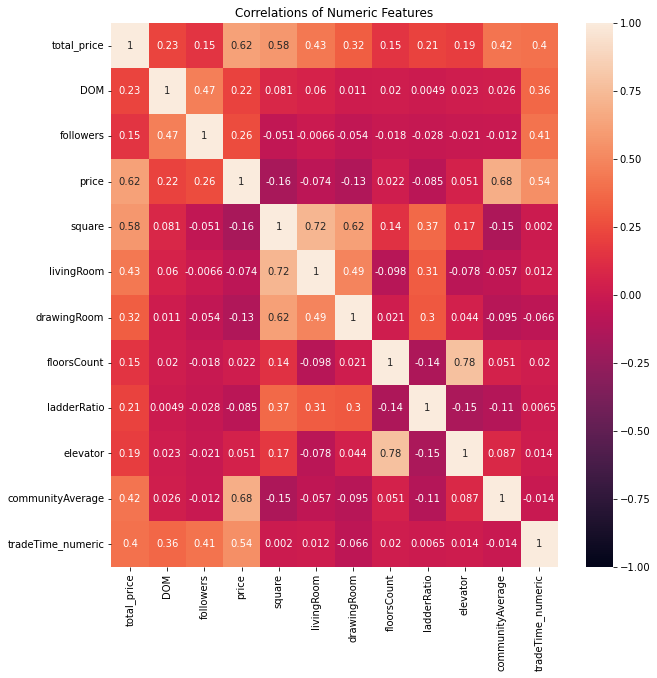

In [34]:
fig,ax = plt.subplots(figsize=(10,10))
sns.heatmap(df[["total_price", "DOM", "followers", "price", "square",
                   "livingRoom", "drawingRoom", "floorsCount", 
                   "ladderRatio", "elevator", "communityAverage",
                   "tradeTime_numeric"]].
                   corr(), annot=True, vmin=-1, vmax=1)
plt.title("Correlations of Numeric Features")

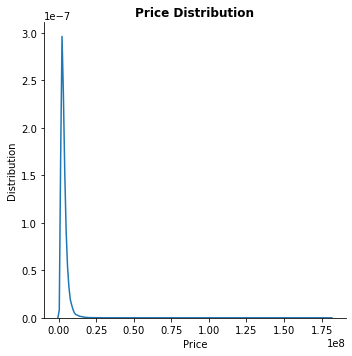

In [35]:
# Distribution plot of target.

sns.displot(data=df, x="total_price", kind="kde")
plt.title("Price Distribution", weight="bold")
plt.xlabel("Price")
plt.ylabel("Distribution");

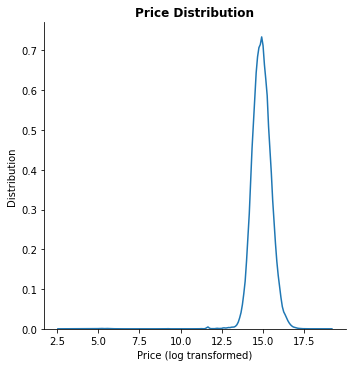

In [36]:
# From above it seems a log transformation might be good.

df["log_total_price"] = np.log(df["total_price"])

sns.displot(data=df, x="log_total_price", kind="kde")
plt.title("Price Distribution", weight="bold")
plt.xlabel("Price (log transformed)")
plt.ylabel("Distribution");


In [37]:
print(f"Number above 20mil: {len(df.query('total_price > 20_000_000')):,}")
print(f"Percent above 20mil: {len(df.query('total_price > 20_000_000')) / len(df):.1%}")

Number above 20mil: 369
Percent above 20mil: 0.1%


In [38]:
print(f"Number below 200k: {len(df.query('total_price < 200_000')):,}")
print(f"Percent below 200k: {len(df.query('total_price < 200_000')) / len(df):.1%}")

Number below 200k: 601
Percent below 200k: 0.2%


In [39]:
print(f"Mean: {df.total_price.mean():,.0f}")

Mean: 3,490,365


## Model Building

In [40]:
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.model_selection import train_test_split

from helpers import (
    calculate_r2_mae_rmse,
    plot_residuals_qqplot_fit
)


In [41]:
df_train = df.query("tradeTime < '2017-01-01'")
df_test = df.query("tradeTime >= '2017-01-01'")

#### Linear regression (OLS), dropping nan values, non-transformed price.

In [42]:
temp_df = df_train.copy()
temp_df = temp_df[["total_price", "DOM", "followers", "price", "square",
                   "livingRoom", "drawingRoom", "floorsCount", 
                   "ladderRatio", "elevator", "communityAverage",
                   "tradeTime_numeric"]]
temp_df = temp_df.dropna()


X = temp_df[["DOM", "followers", "price", "square",
             "livingRoom", "drawingRoom", "floorsCount", 
             "ladderRatio", "elevator", "communityAverage",
             "tradeTime_numeric"]]
y = temp_df["total_price"]

# Split training dataset - 80% train and 20% validation.
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.2,random_state=13)


In [43]:
lm_ols = LinearRegression()
lm_ols.fit(X_train, y_train)

y_validate_predicted = lm_ols.predict(X_validate)

print(calculate_r2_mae_rmse(actual=y_validate, predicted=y_validate_predicted))


R2: 0.8709
MAE: 461,182
RMSE: 815,720


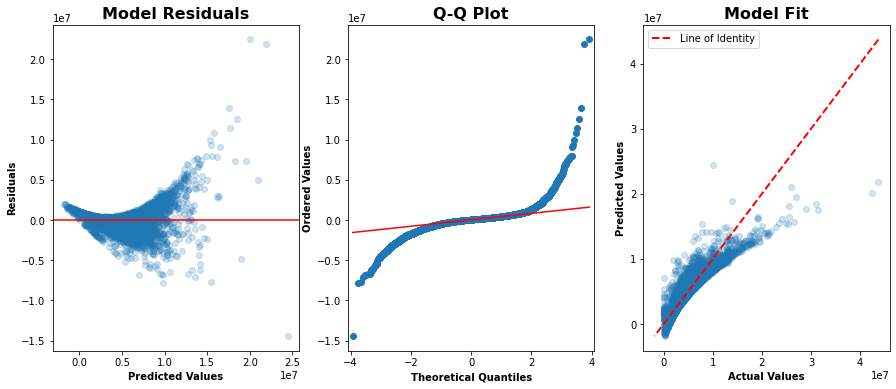

In [44]:
plot_residuals_qqplot_fit(actual=y_validate, predicted=y_validate_predicted);

#### Linear regression (OLS), imputing nan values, non-transformed price.

In [45]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [46]:
temp_df = df_train.copy()

X = temp_df[["DOM", "followers", "price", "square",
             "livingRoom", "drawingRoom", "floorsCount", 
             "ladderRatio", "elevator", "communityAverage",
             "tradeTime_numeric"]]
y = df_train["total_price"]

# Split training dataset - 80% train and 20% validation.
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.2,random_state=13)


imp = IterativeImputer(max_iter=10, random_state=13)
imp.fit(X_train)

X_train = imp.transform(X_train)
X_train = pd.DataFrame(X_train, columns = X.columns)

# Use imputation model on validation dataset.
X_validate = imp.transform(X_validate)
X_validate = pd.DataFrame(X_validate, columns = X.columns)


In [47]:
lm_ols = LinearRegression()
lm_ols.fit(X_train, y_train)

y_validate_predicted = lm_ols.predict(X_validate)

print(calculate_r2_mae_rmse(actual=y_validate, predicted=y_validate_predicted))

R2: 0.8786
MAE: 400,234
RMSE: 701,246


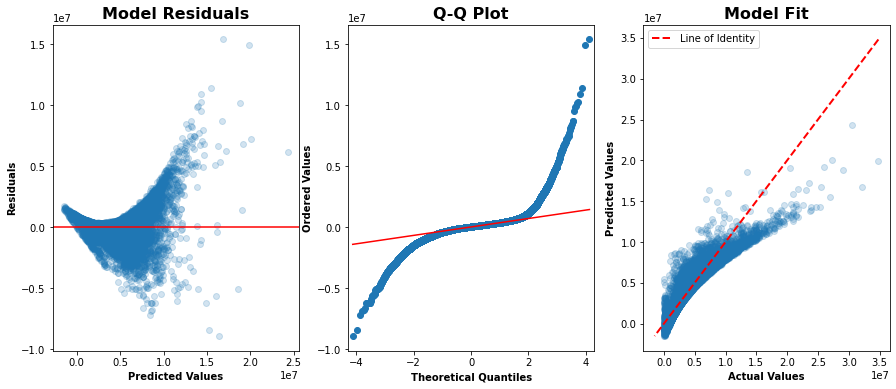

In [48]:
plot_residuals_qqplot_fit(actual=y_validate, predicted=y_validate_predicted);

#### Linear regression (OLS), replacing nan values with means, non-transformed price.

In [49]:
temp_df = df_train.copy()

X = temp_df[["DOM", "followers", "price", "square",
             "livingRoom", "drawingRoom", "floorsCount", 
             "ladderRatio", "elevator", "communityAverage",
             "tradeTime_numeric"]]
y = temp_df["total_price"]

# Split training dataset - 80% train and 20% validation.
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.2,random_state=13)


X_train = X_train.fillna(X_train.mean())
# Use the training dataset means.
X_validate = X_validate.fillna(X_train.mean())


In [50]:
lm_ols = LinearRegression()
lm_ols.fit(X_train, y_train)

y_validate_predicted = lm_ols.predict(X_validate)

print(calculate_r2_mae_rmse(actual=y_validate, predicted=y_validate_predicted))

R2: 0.8792
MAE: 401,949
RMSE: 699,397


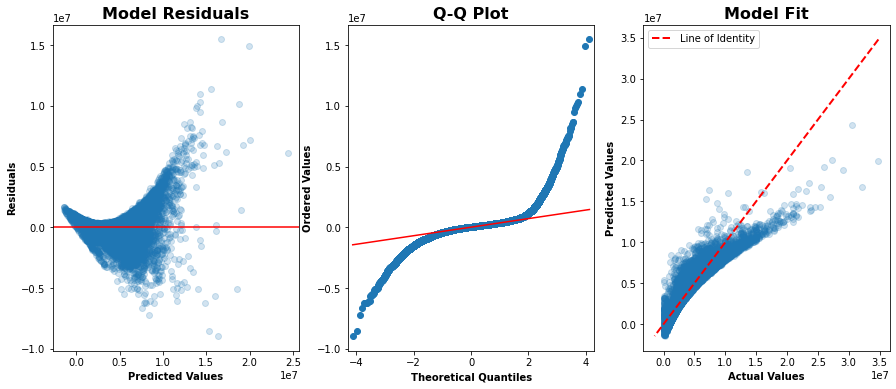

In [51]:
plot_residuals_qqplot_fit(actual=y_validate, predicted=y_validate_predicted);

In [52]:
# Model attributes.

print("Intercept:", lm_ols.intercept_)

print("Coefficients:")
for i, coef in enumerate(lm_ols.coef_):
    print(f"{lm_ols.feature_names_in_[i]}: {coef:.2f}")


Intercept: -96363270.32037532
Coefficients:
DOM: 1211.60
followers: -505.66
price: 71.45
square: 38575.07
livingRoom: -24165.73
drawingRoom: -22443.60
floorsCount: 5491.70
ladderRatio: 451981.31
elevator: 127338.67
communityAverage: 6.11
tradeTime_numeric: 126.23


#### Linear regression (OLS), imputing nan values, log-transformed price.

In [53]:
temp_df = df_train.copy()

X = temp_df[["DOM", "followers", "price", "square",
             "livingRoom", "drawingRoom", "floorsCount", 
             "ladderRatio", "elevator", "communityAverage",
             "tradeTime_numeric"]]
y = df_train["log_total_price"]

# Split training dataset - 80% train and 20% validation.
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.2,random_state=13)


imp = IterativeImputer(max_iter=10, random_state=13)
imp.fit(X_train)

X_train = imp.transform(X_train)
X_train = pd.DataFrame(X_train, columns = X.columns)

# Use imputation model on validation dataset.
X_validate = imp.transform(X_validate)
X_validate = pd.DataFrame(X_validate, columns = X.columns)

In [54]:
lm_ols = LinearRegression()
lm_ols.fit(X_train, y_train)

y_validate_predicted_not_log = np.exp(lm_ols.predict(X_validate))
y_validate_not_log = np.exp(y_validate)

print(calculate_r2_mae_rmse(actual=y_validate_not_log, predicted=y_validate_predicted_not_log))


R2: 0.2866
MAE: 457,495
RMSE: 1,699,613


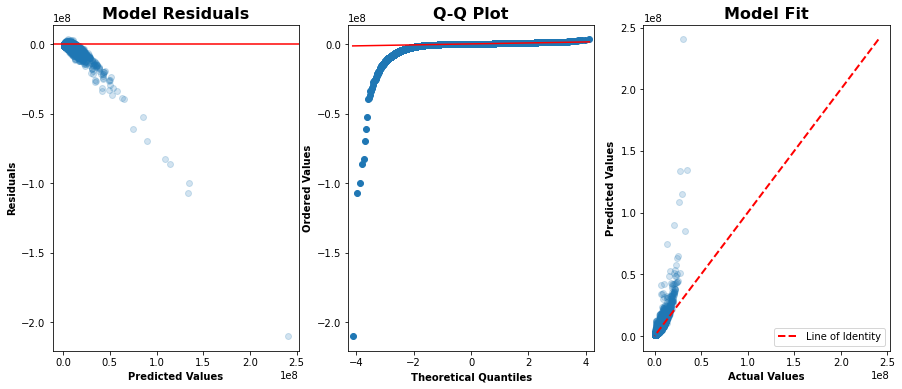

In [55]:
plot_residuals_qqplot_fit(actual=y_validate_not_log, predicted=y_validate_predicted_not_log);

#### Linear regression (OLS), imputing nan values, capping price.

In [56]:
temp_df = df_train.copy()

X = temp_df[["DOM", "followers", "price", "square",
             "livingRoom", "drawingRoom", "floorsCount", 
             "ladderRatio", "elevator", "communityAverage",
             "tradeTime_numeric"]]
y = df_train["total_price"]

# Split training dataset - 80% train and 20% validation.
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.2,random_state=13)


imp = IterativeImputer(max_iter=10, random_state=13)
imp.fit(X_train)

X_train = imp.transform(X_train)
X_train = pd.DataFrame(X_train, columns = X.columns)

# Use imputation model on validation dataset.
X_validate = imp.transform(X_validate)
X_validate = pd.DataFrame(X_validate, columns = X.columns)

# Cap the ends of the spectrum for total_price when training the model (200k to 20mil).
y_train = y_train.apply(lambda x: 20_000_000 if x > 20_000_000 else x)
y_train = y_train.apply(lambda x: 200_000 if x < 200_000 else x)

In [57]:
lm_ols = LinearRegression()
lm_ols.fit(X_train, y_train)

y_validate_predicted = lm_ols.predict(X_validate)

print(calculate_r2_mae_rmse(actual=y_validate, predicted=y_validate_predicted))

R2: 0.8784
MAE: 395,965
RMSE: 701,712


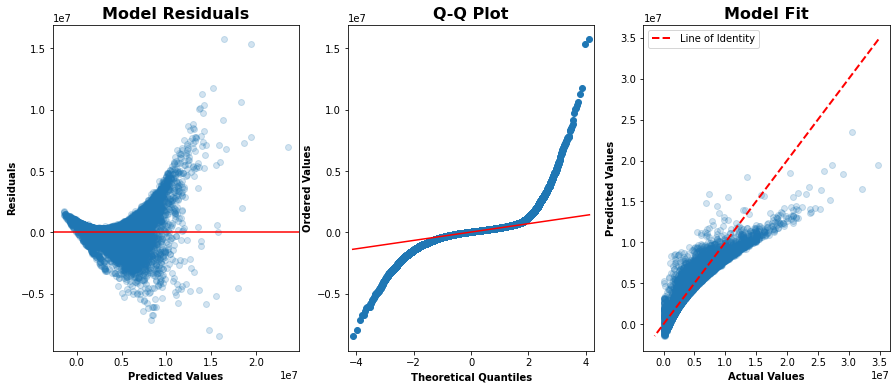

In [58]:
plot_residuals_qqplot_fit(actual=y_validate, predicted=y_validate_predicted);

#### Lasso regression, imputing nan values, non-transformed price.

In [59]:
from sklearn.preprocessing import StandardScaler


In [60]:
temp_df = df_train.copy()

X = temp_df[["DOM", "followers", "price", "square",
             "livingRoom", "drawingRoom", "floorsCount", 
             "ladderRatio", "elevator", "communityAverage",
             "tradeTime_numeric"]]
y = df_train["total_price"]

# Split training dataset - 80% train and 20% validation.
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.2,random_state=13)


imp = IterativeImputer(max_iter=10, random_state=13)
imp.fit(X_train)

X_train = imp.transform(X_train)
X_train = pd.DataFrame(X_train, columns = X.columns)

# Use imputation model on validation dataset.
X_validate = imp.transform(X_validate)
X_validate = pd.DataFrame(X_validate, columns = X.columns)

# Scale features for Lasso.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.values)
X_validate_scaled = scaler.fit_transform(X_validate.values)


In [61]:
# Run cross validation on Lasso regression to find the best alpha. 
# Then will refit the model with that alpha
alphavec = 10**np.linspace(-4,4,1000)
lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_train_scaled, y_train)
# This is the best alpha value it found:
lasso_alpha_to_use = lasso_model.alpha_

lm_lasso = Lasso(alpha=lasso_alpha_to_use)
lm_lasso.fit(X_train_scaled, y_train)

y_validate_predicted = lm_lasso.predict(X_validate_scaled)

print(calculate_r2_mae_rmse(actual=y_validate, predicted=y_validate_predicted))


R2: 0.8785
MAE: 402,558
RMSE: 701,499


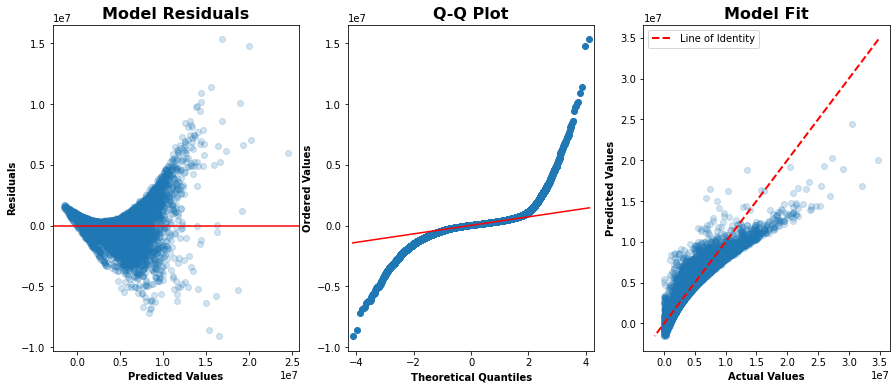

In [62]:
plot_residuals_qqplot_fit(actual=y_validate, predicted=y_validate_predicted);

#### XG Boost, imputing nan values, non-transformed price.

In [63]:
import xgboost as xgb


In [64]:
temp_df = df_train.copy()

X = temp_df[["DOM", "followers", "price", "square",
             "livingRoom", "drawingRoom", "floorsCount", 
             "ladderRatio", "elevator", "communityAverage",
             "tradeTime_numeric"]]
y = df_train["total_price"]

# Split training dataset - 80% train and 20% validation.
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.2,random_state=13)


imp = IterativeImputer(max_iter=10, random_state=13)
imp.fit(X_train)

X_train = imp.transform(X_train)
X_train = pd.DataFrame(X_train, columns = X.columns)

# Use imputation model on validation dataset.
X_validate = imp.transform(X_validate)
X_validate = pd.DataFrame(X_validate, columns = X.columns)

In [65]:
xg_reg = xgb.XGBRegressor(n_estimators=100, max_depth=5, eta=0.1, subsample=0.7, colsample_bytree=0.8)

xg_reg.fit(X_train, y_train)

y_validate_predicted = xg_reg.predict(X_validate)

print(calculate_r2_mae_rmse(actual=y_validate, predicted=y_validate_predicted))


R2: 0.9957
MAE: 81,304
RMSE: 132,134


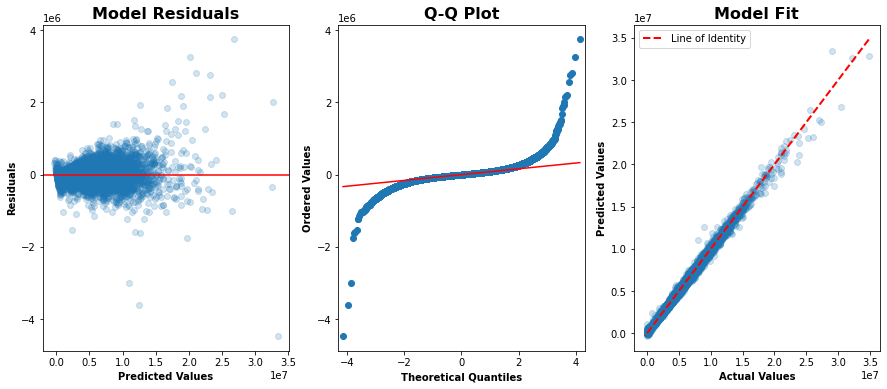

In [66]:
plot_residuals_qqplot_fit(actual=y_validate, predicted=y_validate_predicted);

#### XG Boost, imputing nan values, non-transformed price, including categorical variables.

In [67]:
temp_df = df_train.copy()

X = temp_df[["DOM", "followers", "price", "square",
             "livingRoom", "drawingRoom", "floorsCount", 
             "ladderRatio", "elevator", "communityAverage",
             "tradeTime_numeric",
             "renovationCondition", "floorPositionAbbreviated"]]
X = pd.get_dummies(X, drop_first=False)


y = df_train["total_price"]

# Split training dataset - 80% train and 20% validation.
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.2,random_state=13)


imp = IterativeImputer(max_iter=10, random_state=13)
imp.fit(X_train)

X_train = imp.transform(X_train)
X_train = pd.DataFrame(X_train, columns = X.columns)

# Use imputation model on validation dataset.
X_validate = imp.transform(X_validate)
X_validate = pd.DataFrame(X_validate, columns = X.columns)

In [68]:
xg_reg = xgb.XGBRegressor(n_estimators=100, max_depth=5, eta=0.1, subsample=0.7, colsample_bytree=0.8)

xg_reg.fit(X_train, y_train)

y_validate_predicted = xg_reg.predict(X_validate)

print(calculate_r2_mae_rmse(actual=y_validate, predicted=y_validate_predicted))


R2: 0.9977
MAE: 58,223
RMSE: 96,028


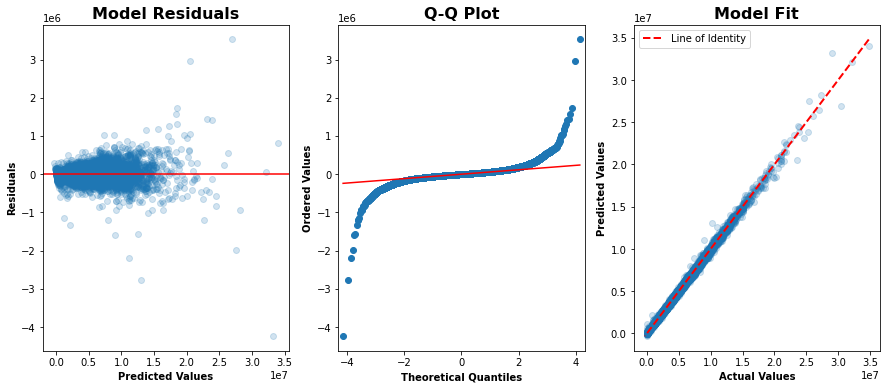

In [69]:
plot_residuals_qqplot_fit(actual=y_validate, predicted=y_validate_predicted);

## Test the best model on the 2017-2018 data.

Chose the XG Boost model that imputes the missing data, uses no transformation of the target, and uses both numeric and categorical data - this model had the highest R2 as well as the lowest error. 

In [70]:
# Train the model with the full training data and prep the test data.

X_train = df_train[["DOM", "followers", "price", "square",
                    "livingRoom", "drawingRoom", "floorsCount", 
                    "ladderRatio", "elevator", "communityAverage",
                    "tradeTime_numeric",
                    "renovationCondition", "floorPositionAbbreviated"]]
X_train = pd.get_dummies(X_train, drop_first=False)

y_train = df_train["total_price"]

X_test = df_test[["DOM", "followers", "price", "square",
                  "livingRoom", "drawingRoom", "floorsCount", 
                  "ladderRatio", "elevator", "communityAverage",
                  "tradeTime_numeric",
                  "renovationCondition", "floorPositionAbbreviated"]]
X_test = pd.get_dummies(X_test, drop_first=False)

# Need to add dummy nan columns to test data if not present:
for column in X_train.columns:
    if ((column not in set(X_test.columns))
        and (column[-4:] == "_nan")
    ):
        X_test[column] = 0
# Need order the same between two datasets.
X_test = X_test[X_train.columns]

y_test = df_test["total_price"]

x_column_labels = X_train.columns

imp = IterativeImputer(max_iter=10, random_state=13)
imp.fit(X_train)

X_train = imp.transform(X_train)
X_train = pd.DataFrame(X_train, columns = x_column_labels)

# Use imputation model on test dataset.
X_test = imp.transform(X_test)
X_test = pd.DataFrame(X_test, columns = x_column_labels)

In [71]:
xg_reg = xgb.XGBRegressor(n_estimators=100, max_depth=5, eta=0.1, subsample=0.7, colsample_bytree=0.8)

xg_reg.fit(X_train, y_train)

y_test_predicted = xg_reg.predict(X_test)

print(calculate_r2_mae_rmse(actual=y_test, predicted=y_test_predicted))

R2: 0.9429
MAE: 103,408
RMSE: 720,983


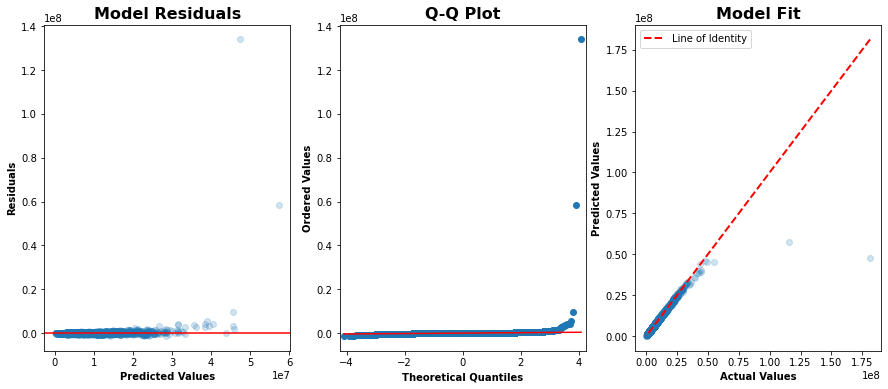

In [72]:
plot_residuals_qqplot_fit(actual=y_test, predicted=y_test_predicted);

In [73]:
# Curious about the outliers.

print("Test Data")
print(f"Median: {y_test.median():,.0f}")
print(f"Mean: {y_test.mean():,.0f}")

print("Top 5 Most Expensive:")
count = 1
for x in sorted(y_test, reverse=True)[:5]:
    print(f"{count}: {x:,.0f}")
    count += 1

Test Data
Median: 4,580,043
Mean: 5,272,396
Top 5 Most Expensive:
1: 181,301,594
2: 116,000,616
3: 55,000,179
4: 49,000,140
5: 48,000,122


In [74]:
# Curious about the outliers.

print("Training Data")
print(f"Median: {y_train.median():,.0f}")
print(f"Mean: {y_train.mean():,.0f}")

print("Top 5 Most Expensive:")
count = 1
for x in sorted(y_train, reverse=True)[:5]:
    print(f"{count}: {x:,.0f}")
    count += 1

Training Data
Median: 2,700,049
Mean: 3,209,299
Top 5 Most Expensive:
1: 60,000,072
2: 57,000,200
3: 46,500,042
4: 43,700,316
5: 43,500,403
